# Task 2: Player Segment Classification

In this task we will have to classified which segment of the user are which are: Casual player, Competitive grinder, Social player, and Whale. We will be using Multi-class classification for as a method for this task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import joblib


## Data Preparation

### Dowload Data

In [2]:
df = pd.read_csv('task2/train.csv')
df.head()

id player_id  play_frequency  avg_session_duration  \
0  PLY00001   P050236        5.495437             24.837349   
1  PLY00002   P108696        9.991089             88.376322   
2  PLY00003   P113532       14.234225            101.712292   
3  PLY00004   P123930        3.373683            191.975841   
4  PLY00005   P068623       22.469353             28.042509   

   total_playtime_hours  login_streak  days_since_last_login  \
0           2740.945124          60.0              56.034052   
1                   NaN          22.0              75.036888   
2           2828.479467          66.0                    NaN   
3           1915.082950          80.0               0.127910   
4            517.921948           NaN              45.078460   

   total_spending_thb  avg_monthly_spending  spending_frequency  ...  \
0        58219.915660            434.038311           17.790970  ...   
1        28966.163953           4233.532935           28.862134  ...   
2        44478.823835           4849.491895           22.536406  ...   
3        57074.116993           6863.516123           10.565666  ...   
4                 NaN           4408.101247           11.226504  ...   

   platform  device_type  payment_method  language  account_status  \
0        PC        Phone          Wallet        DE          Active   
1   Console      Desktop            Card        ES         Dormant   
2        PC       Laptop             NaN        EN         Dormant   
3   Console       Tablet             NaN        ES         Dormant   
4        PC       Tablet            Gift        EN          Active   

   player_type_tag  engagement_level  loyalty_tier  skill_tier  segment  
0           Social               Low        Silver         NaN        0  
1        Collector               Low      Platinum        Gold        2  
2           Casual              High       Diamond        Gold        3  
3      Competitive           Veteran        Silver        Gold        3  
4           Casual               Mid        Silver         NaN        1  

[5 rows x 47 columns]

In [3]:
df['segment'].value_counts()

segment
0    40064
1    25397
2    20549
3    15648
Name: count, dtype: int64

### Data Cleaning Process

In [4]:
def create_null_table(df):
    null_count = df.isnull().sum()
    null_percentage = df.isnull().sum() * 100 / len(df)

    # Create table
    null_table = pd.concat([null_count, null_percentage] ,axis = 1)

    # Rename columns
    null_table = null_table.rename(columns={0: "Missing value counts", 1: "Missing value percentage"})

    # Sort value
    null_table = null_table[null_table.iloc[:,-1] != 0].sort_values('Missing value counts', ascending=False).round(1)
    return null_table

#### Numerical Data Inspection

In [5]:
df.describe().T

count          mean           std  \
play_frequency                     93785.0     12.162113      7.112615   
avg_session_duration               93771.0    107.922960     54.461009   
total_playtime_hours               93887.0   1706.987371    939.497982   
login_streak                       93938.0     55.095968     35.385126   
days_since_last_login              93878.0     45.917386     20.763590   
total_spending_thb                 93902.0  34156.914790  22008.333299   
avg_monthly_spending               93923.0   3304.075003   1929.848230   
spending_frequency                 93898.0     17.000950      9.602913   
friend_count                       93720.0    107.292168     65.017491   
team_play_percentage               93963.0     50.226549     19.707257   
chat_activity_score                93893.0     67.515136     43.562074   
friend_invites_sent                93823.0     43.221438     27.115444   
gifts_sent_received                93938.0     86.758383     54.345783   
ranked_participation_rate          93833.0     49.953316     27.411895   
tournament_entries                 93804.0     27.237815     17.687710   
competitive_rank                   93863.0      4.538157      2.418260   
win_rate_ranked                    93830.0     50.347402     10.057405   
watches_esports                    93776.0      0.402896      0.490483   
achievement_completion_rate        93764.0     50.255567     19.485132   
collection_progress                93744.0     50.348058     19.402525   
rare_items_count                   93964.0     86.837172     55.218191   
speed_of_progression               93831.0      5.565904      3.547631   
item_type_preference_cosmetic      93900.0      0.599646      0.193357   
item_type_preference_performance   93824.0      0.599521      0.192830   
item_type_preference_social        93756.0      0.500765      0.195423   
account_age_days                   93812.0    822.401377    461.302489   
vip_tier                           93882.0      1.297991      1.412312   
responds_to_discounts              93769.0      0.601819      0.489526   
preferred_game_mode                93968.0      1.994328      1.411464   
avg_match_length                   93805.0     35.037961     14.724860   
peak_concurrent_hours              94023.0     55.715694     35.297009   
random_metric_1                    93842.0    498.223300    288.331613   
random_metric_2                    93907.0      0.500032      0.288996   
random_metric_3                    93881.0     99.486957     49.946989   
segment                           101658.0      1.115889      1.094777   

                                           min           25%           50%  \
play_frequency                    1.000033e+00      6.437830     11.449866   
avg_session_duration              2.000584e+01     64.559580    103.028355   
total_playtime_hours              1.000188e+02    973.768239   1645.831217   
login_streak                      0.000000e+00     27.000000     52.000000   
days_since_last_login             6.466683e-03     31.260410     45.724496   
total_spending_thb                5.003089e+02  16368.741422  31528.039053   
avg_monthly_spending              1.000826e+02   1780.923045   3160.767590   
spending_frequency                1.000775e+00      9.445409     16.251247   
friend_count                      0.000000e+00     56.000000    103.000000   
team_play_percentage              5.000000e+00     36.615032     50.172440   
chat_activity_score               1.852541e-03     32.311508     62.764487   
friend_invites_sent               0.000000e+00     22.000000     41.000000   
gifts_sent_received               0.000000e+00     43.000000     82.000000   
ranked_participation_rate         0.000000e+00     29.747045     50.001619   
tournament_entries                0.000000e+00     13.000000     25.000000   
competitive_rank                  0.000000e+00      3.000000      5.000000   
win_rate_ranked                   2.500000e+01

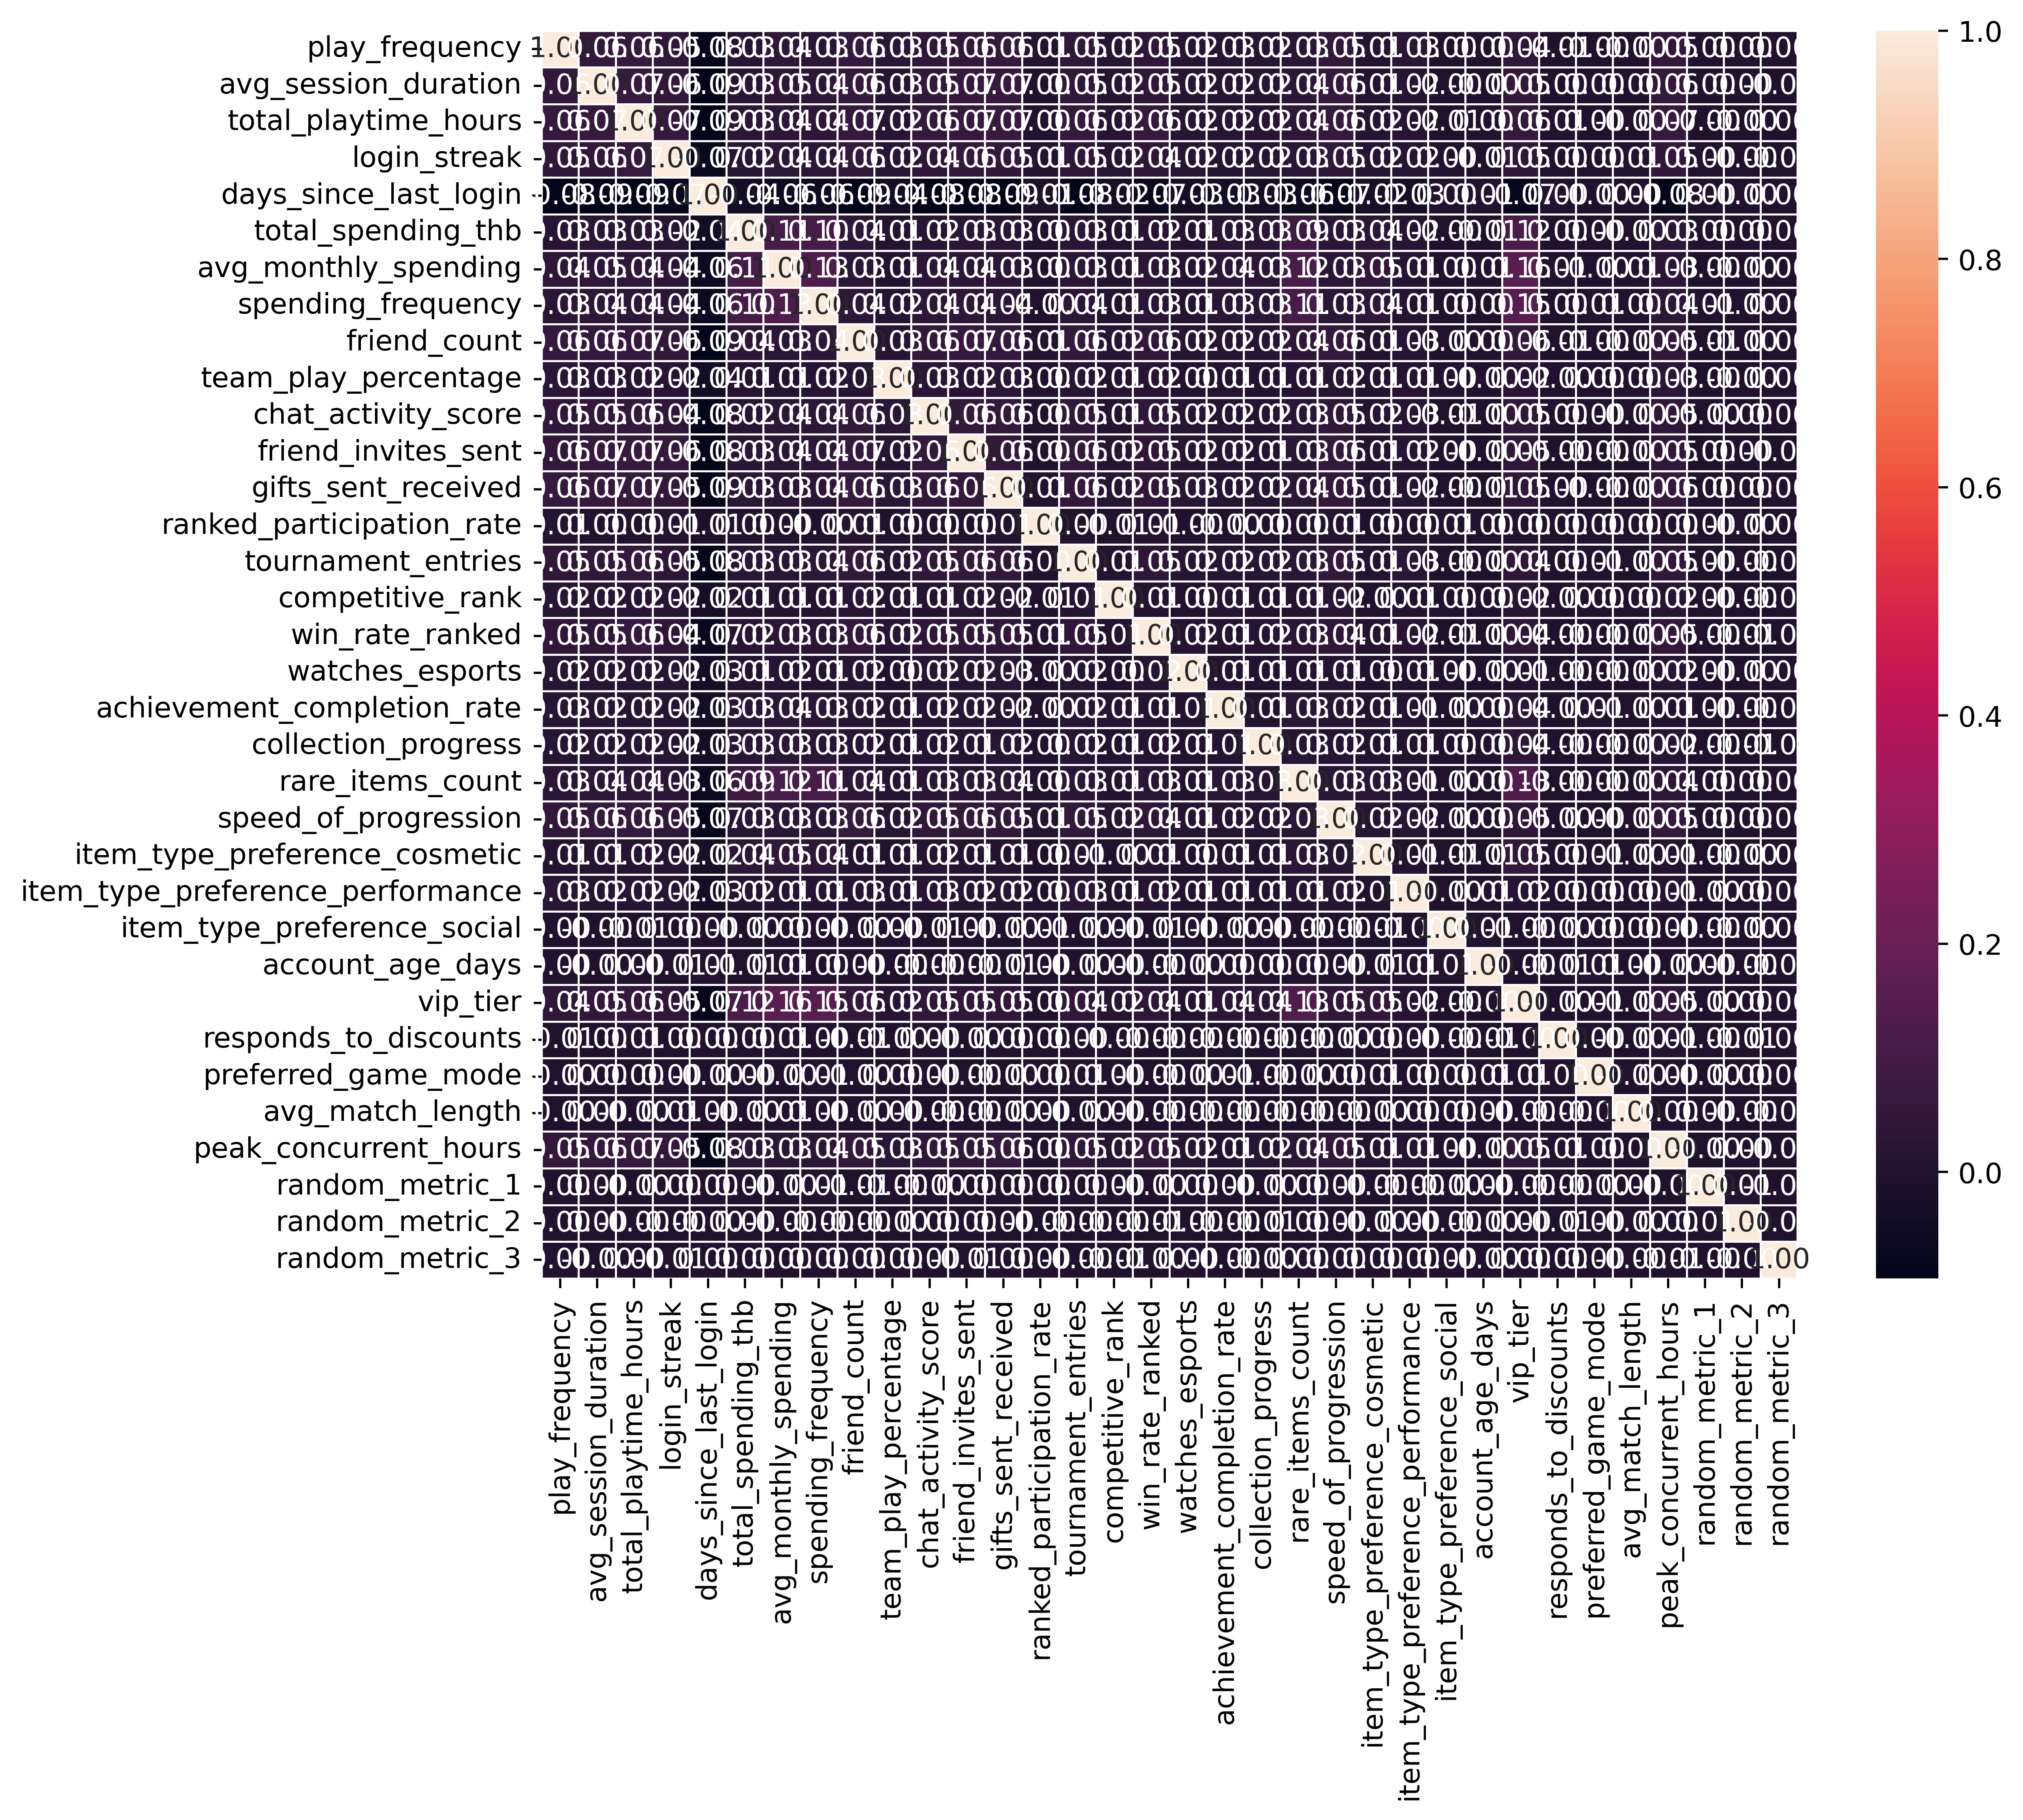

In [6]:
# Find the numerical correlations matrix
df_no_segment = df.drop('segment', axis = 1)
corr = df_no_segment.corr(numeric_only=True)
corr

plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [7]:
def get_highest_corr(corr):
    max_val_list = []
    max_col_list = []
    for i in range(len(corr)):
        max_val = -999
        max_col = ''
        for n,j in enumerate(corr):
            if(n == i): continue
            if(corr[j].iloc[i] > max_val):
                max_col = j
                max_val = corr[j].iloc[i]
        max_val_list.append(max_val)
        max_col_list.append(max_col)
    max_corr = pd.DataFrame(index = corr.index)
    max_corr['max_corr'] = max_val_list
    max_corr['max_pair'] = max_col_list
    max_corr.sort_values('max_corr', ascending = False, inplace = True)
    return max_corr

get_highest_corr(corr)


max_corr                     max_pair
vip_tier                          0.158343         avg_monthly_spending
avg_monthly_spending              0.158343                     vip_tier
spending_frequency                0.150374                     vip_tier
rare_items_count                  0.134382                     vip_tier
total_spending_thb                0.118699                     vip_tier
avg_session_duration              0.072930         total_playtime_hours
total_playtime_hours              0.072930         avg_session_duration
gifts_sent_received               0.072906         total_playtime_hours
friend_count                      0.068609         total_playtime_hours
login_streak                      0.067286         total_playtime_hours
friend_invites_sent               0.067111                 friend_count
peak_concurrent_hours             0.066432         total_playtime_hours
play_frequency                    0.064699         total_playtime_hours
speed_of_progression              0.064431         total_playtime_hours
tournament_entries                0.062340         total_playtime_hours
win_rate_ranked                   0.061943         total_playtime_hours
chat_activity_score               0.060569          gifts_sent_received
item_type_preference_cosmetic     0.054584                     vip_tier
achievement_completion_rate       0.037162         avg_monthly_spending
collection_progress               0.035369                     vip_tier
item_type_preference_performance  0.029705           tournament_entries
team_play_percentage              0.028682          gifts_sent_received
watches_esports                   0.027999          gifts_sent_received
competitive_rank                  0.024291                 friend_count
ranked_participation_rate         0.012683              win_rate_ranked
random_metric_1                   0.007839              random_metric_2
random_metric_2                   0.007839              random_metric_1
account_age_days                  0.007019         avg_monthly_spending
responds_to_discounts             0.006996         avg_monthly_spending
preferred_game_mode               0.006938  achievement_completion_rate
item_type_preference_social       0.006342    ranked_participation_rate
days_since_last_login             0.005724             account_age_days
avg_match_length                  0.005370         avg_monthly_spending
random_metric_3                   0.004618        days_since_last_login

From the observatioon, each column are not having much of a correlation to each other, so we considered to leave them as they were

#### Categorical & Segment pairing matching distribution count


Let's start of with the numerical data that technically should have stored as categorical

In [8]:
df['watches_esports'].isnull().sum()

np.int64(7882)

In [9]:
df[['watches_esports', 'segment']].value_counts()

watches_esports  segment
0.0              0          23360
1.0              0          13608
0.0              1          13017
                 2          11730
1.0              1          10448
0.0              3           7887
1.0              2           7213
                 3           6513
Name: count, dtype: int64

From the data, it is pretty clear that for every segment, the amount of people watching esports will be less than the people who doesn't, and there also non significant one to be found here...

In [10]:
df[['preferred_game_mode', 'segment']].value_counts()

preferred_game_mode  segment
0.0                  0          7544
3.0                  0          7468
2.0                  0          7411
1.0                  0          7368
4.0                  0          7174
2.0                  1          4786
1.0                  1          4734
4.0                  1          4712
3.0                  1          4660
0.0                  1          4647
3.0                  2          3844
1.0                  2          3837
4.0                  2          3813
0.0                  2          3752
2.0                  2          3727
                     3          2995
3.0                  3          2917
0.0                  3          2912
1.0                  3          2835
4.0                  3          2832
Name: count, dtype: int64

In [11]:
df[['vip_tier', 'segment']].value_counts()

vip_tier  segment
0.0       0          22052
          1           9432
1.0       0           7343
          1           7052
          2           5573
0.0       2           3937
2.0       0           3837
          2           3794
          3           3578
          1           3457
1.0       3           2895
3.0       2           2840
          3           2835
          1           2407
4.0       3           2066
3.0       0           1875
4.0       2           1821
0.0       3           1783
5.0       3           1349
4.0       0           1148
          1           1133
5.0       2            932
          0            718
          1             25
Name: count, dtype: int64

Now, let's take a look on the actual categorical data

In [12]:
df[['account_status', 'segment']].value_counts()

account_status  segment
Dormant         0          18571
Active          0          18515
Dormant         1          11720
Active          1          11707
Dormant         2           9517
Active          2           9470
                3           7333
Dormant         3           7108
Name: count, dtype: int64

In [13]:
df[['player_type_tag', 'segment']].value_counts()

player_type_tag  segment
Collector        0          9383
Social           0          9275
Casual           0          9244
Competitive      0          9025
Casual           1          6041
Social           1          5890
Collector        1          5803
Competitive      1          5720
Collector        2          4853
Social           2          4755
Casual           2          4669
Competitive      2          4649
Casual           3          3660
Social           3          3618
Competitive      3          3597
Collector        3          3556
Name: count, dtype: int64

In [14]:
df[['language', 'segment']].value_counts()

language  segment
JP        0          6194
FR        0          6182
ES        0          6173
EN        0          6159
KR        0          6101
DE        0          6095
          1          3981
KR        1          3919
FR        1          3892
EN        1          3888
ES        1          3884
JP        1          3883
KR        2          3239
DE        2          3204
FR        2          3188
ES        2          3155
JP        2          3115
EN        2          3112
DE        3          2423
ES        3          2411
FR        3          2409
JP        3          2404
KR        3          2385
EN        3          2364
Name: count, dtype: int64

In [15]:
df[['payment_method', 'segment']].value_counts()
# this also tell us nothing

payment_method  segment
Gift            0          9351
Card            0          9327
Wallet          0          9147
                1          5897
Gift            1          5889
Card            1          5768
Wallet          2          4818
Gift            2          4812
Card            2          4673
                3          3649
Gift            3          3623
Wallet          3          3559
Name: count, dtype: int64

In [16]:
df[['device_type', 'segment']].value_counts()

device_type  segment
Desktop      0          9357
Phone        0          9261
Laptop       0          9257
Tablet       0          9163
Phone        1          5943
Laptop       1          5876
Desktop      1          5805
Tablet       1          5803
Phone        2          4770
Tablet       2          4763
Desktop      2          4717
Laptop       2          4715
Tablet       3          3674
Phone        3          3593
Desktop      3          3584
Laptop       3          3563
Name: count, dtype: int64

In [17]:
df[['platform', 'segment']].value_counts()

platform  segment
PC        0          12421
Mobile    0          12404
Console   0          12234
PC        1           7830
Console   1           7825
Mobile    1           7813
Console   2           6409
Mobile    2           6302
PC        2           6265
Console   3           4894
PC        3           4814
Mobile    3           4766
Name: count, dtype: int64

In [18]:
df[['region', 'segment']].value_counts()

region  segment
LATAM   0          7424
EU      0          7412
APAC    0          7367
AS      0          7352
        1          4724
LATAM   1          4709
EU      1          4668
APAC    1          4665
        2          3860
AS      2          3828
EU      2          3777
LATAM   2          3762
AS      3          3001
EU      3          2921
LATAM   3          2911
APAC    3          2742
Name: count, dtype: int64

From the observation, we can conclude that all of the categorical data (+`watches_esports` and `preferred_game_mode`) are not good for giving us a significant data for training the model becuase they have *uniform distribution*, this mean that they have the same chance to be happend for every possible outcome. So we considered drop all of it

#### Ordinal & Segment Matching count

In [ ]:
df[['engagement_level', 'segment']].value_counts()

engagement_level  segment
Low               0          18316
Mid               0          14752
                  1           9418
Low               2           9381
High              1           9042
Mid               2           7556
High              3           5793
Mid               3           5622
High              0           3809
Low               1           2590
Veteran           1           2300
High              2           1979
Low               3           1632
Veteran           3           1434
                  2             42
                  0             30
Name: count, dtype: int64

In [20]:
df['engagement_level'].mode()

0    Mid
Name: engagement_level, dtype: object

In [21]:
df[['loyalty_tier', 'segment']].value_counts()

loyalty_tier  segment
Bronze        0          18407
Silver        0          14686
Bronze        1          11445
Silver        1           9364
Platinum      2           5663
Gold          2           5522
Platinum      3           4230
Gold          3           4179
Silver        2           3858
Gold          0           3810
Diamond       2           3645
Silver        3           2974
Diamond       3           2773
Gold          1           2431
Bronze        2            313
              3            291
Platinum      1            104
              0             95
Diamond       0             66
              1             65
Name: count, dtype: int64

In [22]:
df['loyalty_tier'].mode()

0    Silver
Name: loyalty_tier, dtype: object

In [23]:
df[['skill_tier', 'segment']].value_counts()

skill_tier  segment
Bronze      0          9317
Silver      0          9181
Gold        0          7230
Bronze      1          5909
Silver      1          5856
Platinum    0          5760
Diamond     0          5413
Bronze      2          4876
Gold        1          4715
Silver      2          4652
Gold        2          3779
Bronze      3          3672
Silver      3          3633
Diamond     1          3512
Platinum    1          3489
            2          2867
Gold        3          2840
Diamond     2          2792
Platinum    3          2158
Diamond     3          2145
Name: count, dtype: int64

In [24]:
df['skill_tier'].mode()

0    Bronze
Name: skill_tier, dtype: object

For the categorical data that is ordinal, they are not have an uniform distribution, so we considered to keep them for the training process.

#### Reconstructed data and Filled the missing value

In [ ]:
unused_cols = ['id', 
               'player_id', 
               'watches_esports', 
               'preferred_game_mode', 
               'random_metric_1', 
               'random_metric_2', 
               'random_metric_3']

df.drop(columns = unused_cols, inplace = True)

We found that in datacard, they state that the column *random_metric_x* are just a random noises, so we include them into the unusued_cols to avoid the model become messy.

#### Ordinal data

In [26]:
def showRatio(df, column):
    count = dict(df[column].value_counts())
    count['null'] = df[column].isnull().sum()
    plt.bar(x=count.keys(), height = count.values())

In [27]:
# These are the categorical that we can replace them with numeric as ranking instead
to_num_cat = ['engagement_level', 'loyalty_tier', 'skill_tier']

Engagement_level

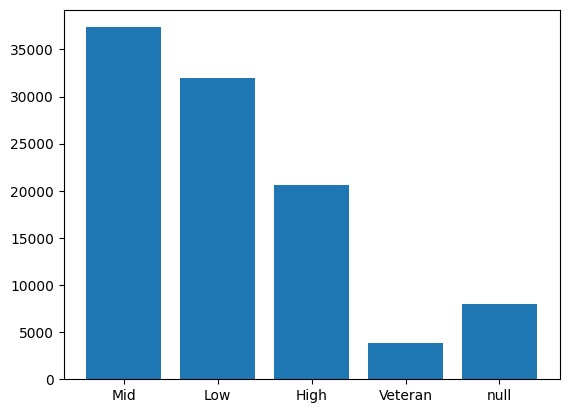

In [28]:
showRatio(df, 'engagement_level')

Loyalty_tier

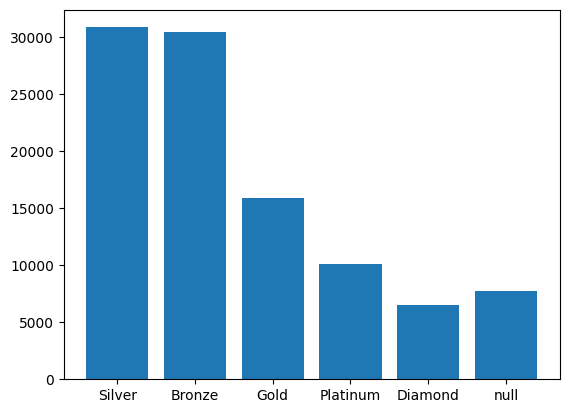

In [29]:
showRatio(df, 'loyalty_tier')

Skill tier

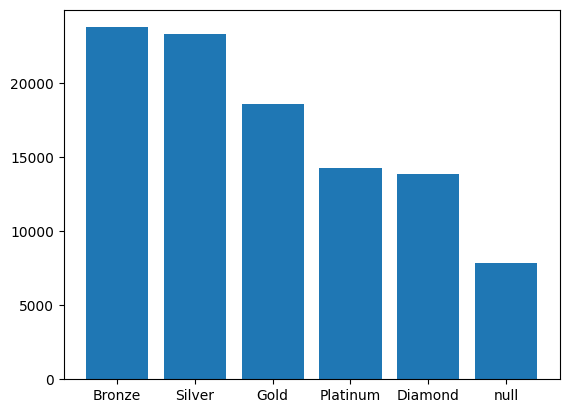

In [30]:
showRatio(df, 'skill_tier')

In [31]:
ranks = {
'engagement_level': {'Low': 0, 'Mid':1, 'High': 2, 'Veteran': 3},
'loyalty_tier': {'Bronze': 0, 'Silver':1, 'Gold': 2, 'Platinum': 3, 'Diamond': 4},
'skill_tier': {'Bronze': 0, 'Silver':1, 'Gold': 2, 'Platinum': 3, 'Diamond': 4},
}

#map rank
for i in to_num_cat:
    df[i] = df[i].map(ranks[i])

df.head()

play_frequency  avg_session_duration  total_playtime_hours  login_streak  \
0        5.495437             24.837349           2740.945124          60.0   
1        9.991089             88.376322                   NaN          22.0   
2       14.234225            101.712292           2828.479467          66.0   
3        3.373683            191.975841           1915.082950          80.0   
4       22.469353             28.042509            517.921948           NaN   

   days_since_last_login  total_spending_thb  avg_monthly_spending  \
0              56.034052        58219.915660            434.038311   
1              75.036888        28966.163953           4233.532935   
2                    NaN        44478.823835           4849.491895   
3               0.127910        57074.116993           6863.516123   
4              45.078460                 NaN           4408.101247   

   spending_frequency  friend_count  team_play_percentage  ...  platform  \
0           17.790970          58.0                   NaN  ...        PC   
1           28.862134         276.0             52.789877  ...   Console   
2           22.536406          71.0             58.267306  ...        PC   
3           10.565666         105.0             67.274038  ...   Console   
4           11.226504         111.0                   NaN  ...        PC   

   device_type  payment_method  language  account_status  player_type_tag  \
0        Phone          Wallet        DE          Active           Social   
1      Desktop            Card        ES         Dormant        Collector   
2       Laptop             NaN        EN         Dormant           Casual   
3       Tablet             NaN        ES         Dormant      Competitive   
4       Tablet            Gift        EN          Active           Casual   

   engagement_level  loyalty_tier  skill_tier  segment  
0               0.0           1.0         NaN        0  
1               0.0           3.0         2.0        2  
2               2.0           4.0         2.0        3  
3               3.0           1.0         2.0        3  
4               1.0           1.0         NaN        1  

[5 rows x 40 columns]

#### Numerical Data

In [32]:
df_num = df.select_dtypes('number')
df_num.drop('segment', axis = 1, inplace = True)
df_num.columns

Index(['play_frequency', 'avg_session_duration', 'total_playtime_hours',
       'login_streak', 'days_since_last_login', 'total_spending_thb',
       'avg_monthly_spending', 'spending_frequency', 'friend_count',
       'team_play_percentage', 'chat_activity_score', 'friend_invites_sent',
       'gifts_sent_received', 'ranked_participation_rate',
       'tournament_entries', 'competitive_rank', 'win_rate_ranked',
       'achievement_completion_rate', 'collection_progress',
       'rare_items_count', 'speed_of_progression',
       'item_type_preference_cosmetic', 'item_type_preference_performance',
       'item_type_preference_social', 'account_age_days', 'vip_tier',
       'responds_to_discounts', 'avg_match_length', 'peak_concurrent_hours',
       'engagement_level', 'loyalty_tier', 'skill_tier'],
      dtype='object')

In [33]:
num_null = create_null_table(df_num)

num_null

Missing value counts  \
engagement_level                                  7962   
friend_count                                      7938   
collection_progress                               7914   
item_type_preference_social                       7902   
achievement_completion_rate                       7894   
responds_to_discounts                             7889   
avg_session_duration                              7887   
play_frequency                                    7873   
skill_tier                                        7862   
tournament_entries                                7854   
avg_match_length                                  7853   
account_age_days                                  7846   
friend_invites_sent                               7835   
item_type_preference_performance                  7834   
win_rate_ranked                                   7828   
speed_of_progression                              7827   
ranked_participation_rate                         7825   
competitive_rank                                  7795   
days_since_last_login                             7780   
vip_tier                                          7776   
total_playtime_hours                              7771   
chat_activity_score                               7765   
spending_frequency                                7760   
item_type_preference_cosmetic                     7758   
total_spending_thb                                7756   
loyalty_tier                                      7737   
avg_monthly_spending                              7735   
login_streak                                      7720   
gifts_sent_received                               7720   
team_play_percentage                              7695   
rare_items_count                                  7694   
peak_concurrent_hours                             7635   

                                  Missing value percentage  
engagement_level                                       7.8  
friend_count                                           7.8  
collection_progress                                    7.8  
item_type_preference_social                            7.8  
achievement_completion_rate                            7.8  
responds_to_discounts                                  7.8  
avg_session_duration                                   7.8  
play_frequency                                         7.7  
skill_tier                                             7.7  
tournament_entries                                     7.7  
avg_match_length                                       7.7  
account_age_days                                       7.7  
friend_invites_sent                                    7.7  
item_type_preference_performance                       7.7  
win_rate_ranked                                        7.7  
speed_of_progression                                   7.7  
ranked_participation_rate                              7.7  
competitive_rank                                       7.7  
days_since_last_login                                  7.7  
vip_tier                                               7.6  
total_playtime_hours                                   7.6  
chat_activity_score                                    7.6  
spending_frequency                                     7.6  
item_type_preference_cosmetic                          7.6  
total_spending_thb                                     7.6  
loyalty_tier                                           7.6  
avg_monthly_spending                                   7.6  
login_streak                                           7.6  
gifts_sent_received                                    7.6  
team_play_percentage                                   7.6  
rare_items_count                                       7.6  
peak_concurrent_hours                                  7.5

Since the number of null value are really close for each columns, we would like to check whether it is related to each other.

In [34]:
df_num_drop = df_num.dropna(subset = ['peak_concurrent_hours'], how = 'any')

create_null_table(df_num_drop)

Missing value counts  \
engagement_level                                  7358   
collection_progress                               7340   
friend_count                                      7327   
skill_tier                                        7316   
play_frequency                                    7307   
win_rate_ranked                                   7301   
item_type_preference_social                       7300   
avg_match_length                                  7293   
responds_to_discounts                             7292   
achievement_completion_rate                       7288   
avg_session_duration                              7282   
account_age_days                                  7268   
tournament_entries                                7250   
item_type_preference_performance                  7247   
speed_of_progression                              7245   
friend_invites_sent                               7235   
competitive_rank                                  7231   
ranked_participation_rate                         7229   
days_since_last_login                             7215   
chat_activity_score                               7215   
vip_tier                                          7208   
item_type_preference_cosmetic                     7204   
spending_frequency                                7172   
total_playtime_hours                              7163   
loyalty_tier                                      7153   
total_spending_thb                                7152   
login_streak                                      7147   
avg_monthly_spending                              7143   
rare_items_count                                  7137   
gifts_sent_received                               7127   
team_play_percentage                              7095   

                                  Missing value percentage  
engagement_level                                       7.8  
collection_progress                                    7.8  
friend_count                                           7.8  
skill_tier                                             7.8  
play_frequency                                         7.8  
win_rate_ranked                                        7.8  
item_type_preference_social                            7.8  
avg_match_length                                       7.8  
responds_to_discounts                                  7.8  
achievement_completion_rate                            7.8  
avg_session_duration                                   7.7  
account_age_days                                       7.7  
tournament_entries                                     7.7  
item_type_preference_performance                       7.7  
speed_of_progression                                   7.7  
friend_invites_sent                                    7.7  
competitive_rank                                       7.7  
ranked_participation_rate                              7.7  
days_since_last_login                                  7.7  
chat_activity_score                                    7.7  
vip_tier                                               7.7  
item_type_preference_cosmetic                          7.7  
spending_frequency                                     7.6  
total_playtime_hours                                   7.6  
loyalty_tier                                           7.6  
total_spending_thb                                     7.6  
login_streak                                           7.6  
avg_monthly_spending                                   7.6  
rare_items_count                                       7.6  
gifts_sent_received                                    7.6  
team_play_percentage                                   7.5

The result sadly is *no*, so we have to approach with other method instead.

##### Replace the missing value

We decide to use iterative imputer as our impute method, since the data seems to be missing by random.

In [35]:
df_mice = df_num.copy(deep = True)
mice_imputer = IterativeImputer()
mice_imputer.fit(df_mice)

df_mice = mice_imputer.transform(df_mice)


In [36]:
df_num_filled = pd.DataFrame(df_mice, columns = df_num.columns)

df_num_filled

play_frequency  avg_session_duration  total_playtime_hours  \
0             5.495437             24.837349           2740.945124   
1             9.991089             88.376322           1537.163170   
2            14.234225            101.712292           2828.479467   
3             3.373683            191.975841           1915.082950   
4            22.469353             28.042509            517.921948   
...                ...                   ...                   ...   
101653       17.189970            125.413304           4042.198275   
101654        7.560260            120.962552           1799.108384   
101655       11.785446             38.541917           1097.814242   
101656       12.898003             64.701401           3563.506452   
101657       15.265967            130.211828            624.018328   

        login_streak  days_since_last_login  total_spending_thb  \
0          60.000000              56.034052        58219.915660   
1          22.000000              75.036888        28966.163953   
2          66.000000              40.214296        44478.823835   
3          80.000000               0.127910        57074.116993   
4          55.628951              45.078460        33687.029245   
...              ...                    ...                 ...   
101653     47.000000              42.264454        30455.881472   
101654     20.000000              27.647682        29782.184066   
101655     25.000000              47.154030        32696.765123   
101656    120.000000               6.810932        48523.945493   
101657     58.000000               0.185670        48073.883470   

        avg_monthly_spending  spending_frequency  friend_count  \
0                 434.038311           17.790970          58.0   
1                4233.532935           28.862134         276.0   
2                4849.491895           22.536406          71.0   
3                6863.516123           10.565666         105.0   
4                4408.101247           11.226504         111.0   
...                      ...                 ...           ...   
101653           5058.189653            9.852469         179.0   
101654           1516.687257            8.235531          52.0   
101655           3147.264423            9.703321         149.0   
101656           1596.091703           31.721567         193.0   
101657           7415.983681           27.716821          90.0   

        team_play_percentage  ...  item_type_preference_performance  \
0                  47.736311  ...                          0.711343   
1                  52.789877  ...                          0.518944   
2                  58.267306  ...                          0.716110   
3                  67.274038  ...                          0.284904   
4                  50.667682  ...                          0.917933   
...                      ...  ...                               ...   
101653             11.689707  ...                          0.659655   
101654              5.000000  ...                          0.241274   
101655             44.062523  ...                          0.582156   
101656             59.351458  ...                          0.423887   
101657             32.047768  ...                          0.950000   

        item_type_preference_social  account_age_days  vip_tier  \
0                          0.640052             503.0  0.000000   
1                          0.325880             500.0  3.000000   
2                          0.481974            1390.0  3.000000   
3                          0.476129            1123.0  3.000000   
4                          0.284007             580.0  2.000000   
...                             ...               ...       ...   
101653                     0.427205            1056.0  1.000000   
101654                     0.506126             956.0  1.000000   
101655                     0.950000             458.0  1.128105   
101656                     0.432693           

In [37]:
# fig, ax = plt.subplots(len(df_num_filled.columns), 1, figsize=(8, 40))

# for i, col in enumerate(df_num_filled.columns):
#     ax[i].hist(df_num_filled[col])
#     ax[i].set_title(col)

# plt.tight_layout()
# plt.show()


From observing the distribution, it is shown that, the data are *skewed*, and we need to do something with it. So, we ending up using `boxcox` transform as a method for this problem.


In [38]:
# from scipy import stats
# for col in df_num_filled.columns:
#     print(col)
#     df_num_filled[col] = stats.boxcox(df_num_filled[col] + 1)[0]

In [39]:
# fig, ax = plt.subplots(len(df_num_filled.columns), 1, figsize=(8, 40))

# for i, col in enumerate(df_num_filled.columns):
#     ax[i].hist(df_num_filled[col])
#     ax[i].set_title(col)

# plt.tight_layout()
# plt.show()


After we have transform the data, the distribution is really much better from before and really to be used.

#### Categorical Data

Since we considered drop the categorical features because it does not tell any significant information (every segment have the same amount of each categorical values). We then can do nothing in this section

### Final data

In [40]:
df_prep = df_num_filled

df_prep.head()

play_frequency  avg_session_duration  total_playtime_hours  login_streak  \
0        5.495437             24.837349           2740.945124     60.000000   
1        9.991089             88.376322           1537.163170     22.000000   
2       14.234225            101.712292           2828.479467     66.000000   
3        3.373683            191.975841           1915.082950     80.000000   
4       22.469353             28.042509            517.921948     55.628951   

   days_since_last_login  total_spending_thb  avg_monthly_spending  \
0              56.034052        58219.915660            434.038311   
1              75.036888        28966.163953           4233.532935   
2              40.214296        44478.823835           4849.491895   
3               0.127910        57074.116993           6863.516123   
4              45.078460        33687.029245           4408.101247   

   spending_frequency  friend_count  team_play_percentage  ...  \
0           17.790970          58.0             47.736311  ...   
1           28.862134         276.0             52.789877  ...   
2           22.536406          71.0             58.267306  ...   
3           10.565666         105.0             67.274038  ...   
4           11.226504         111.0             50.667682  ...   

   item_type_preference_performance  item_type_preference_social  \
0                          0.711343                     0.640052   
1                          0.518944                     0.325880   
2                          0.716110                     0.481974   
3                          0.284904                     0.476129   
4                          0.917933                     0.284007   

   account_age_days  vip_tier  responds_to_discounts  avg_match_length  \
0             503.0       0.0               1.000000         39.255174   
1             500.0       3.0               0.000000         60.140761   
2            1390.0       3.0               0.598159         26.718983   
3            1123.0       3.0               1.000000         13.432821   
4             580.0       2.0               0.603986         35.078723   

   peak_concurrent_hours  engagement_level  loyalty_tier  skill_tier  
0              22.813403               0.0           1.0    1.703968  
1              25.409615               0.0           3.0    2.000000  
2              59.151505               2.0           4.0    2.000000  
3              47.247822               3.0           1.0    2.000000  
4              47.015102               1.0           1.0    1.685142  

[5 rows x 32 columns]

In [41]:
df_prep.isnull().any()

play_frequency                      False
avg_session_duration                False
total_playtime_hours                False
login_streak                        False
days_since_last_login               False
total_spending_thb                  False
avg_monthly_spending                False
spending_frequency                  False
friend_count                        False
team_play_percentage                False
chat_activity_score                 False
friend_invites_sent                 False
gifts_sent_received                 False
ranked_participation_rate           False
tournament_entries                  False
competitive_rank                    False
win_rate_ranked                     False
achievement_completion_rate         False
collection_progress                 False
rare_items_count                    False
speed_of_progression                False
item_type_preference_cosmetic       False
item_type_preference_performance    False
item_type_preference_social       

reconstruct function for later uses.

In [ ]:
unused_cols = ['id', 'player_id', 'watches_esports', 'preferred_game_mode', 
               'random_metric_1', 'random_metric_2', 'random_metric_3']
to_num_cat = ['engagement_level', 'loyalty_tier', 'skill_tier']
ranks = {
'engagement_level': {'Low': 0, 'Mid':1, 'High': 2, 'Veteran': 3},
'loyalty_tier': {'Bronze': 0, 'Silver':1, 'Gold': 2, 'Platinum': 3, 'Diamond': 4},
'skill_tier': {'Bronze': 0, 'Silver':1, 'Gold': 2, 'Platinum': 3, 'Diamond': 4},
}

def cleanData(input, imputer = mice_imputer):
    # Drop unused columns
    df = input.copy()
    df.drop(columns = unused_cols, inplace = True)

    # Ordinal data
    for i in to_num_cat:
        df[i] = df[i].map(ranks[i])

    # Split data to get numerical and ordinal data
    df_num = df.select_dtypes('number')

    # Impute Data
    df_mice = df_num.copy(deep=True)
    df_mice = imputer.transform(df_mice)
    df_num_filled = pd.DataFrame(df_mice, columns = df_num.columns)

    # df_num_filled += 1
    # for col in df_num_filled.columns:
    #     df_num_filled[col] = stats.boxcox(df_num_filled[col])[0]

    return df_num_filled

### Feature Enineering

From observing that columns, We have spot that there are some of columns that are *clearly* indicate that behavior that related to some segment, so we try to merge them as the *intensity*. From the trials that we have done, only the social intensity have effect the result of models, and for other, they getting worse.

In [43]:
df_prep["social_intensity"] = (
    df_prep["friend_count"]
    + df_prep["friend_invites_sent"]
    + df_prep["gifts_sent_received"]
)

df_prep["team_to_solo_ratio"] = df_prep["team_play_percentage"] / (100 - df_prep["team_play_percentage"] + 1)

df_prep["value_per_baht"] = df_prep["avg_session_duration"] / (df_prep["avg_monthly_spending"] + 1)

df_prep.drop(['friend_count', 'friend_invites_sent', 'gifts_sent_received', 'team_play_percentage'],axis = 1, inplace = True)

In [44]:
df_prep.head()

play_frequency  avg_session_duration  total_playtime_hours  login_streak  \
0        5.495437             24.837349           2740.945124     60.000000   
1        9.991089             88.376322           1537.163170     22.000000   
2       14.234225            101.712292           2828.479467     66.000000   
3        3.373683            191.975841           1915.082950     80.000000   
4       22.469353             28.042509            517.921948     55.628951   

   days_since_last_login  total_spending_thb  avg_monthly_spending  \
0              56.034052        58219.915660            434.038311   
1              75.036888        28966.163953           4233.532935   
2              40.214296        44478.823835           4849.491895   
3               0.127910        57074.116993           6863.516123   
4              45.078460        33687.029245           4408.101247   

   spending_frequency  chat_activity_score  ranked_participation_rate  ...  \
0           17.790970             5.579423                  72.746122  ...   
1           28.862134            15.774698                  53.064441  ...   
2           22.536406            26.083790                  35.880592  ...   
3           10.565666            91.135436                  79.392530  ...   
4           11.226504           136.425680                  28.997884  ...   

   vip_tier  responds_to_discounts  avg_match_length  peak_concurrent_hours  \
0       0.0               1.000000         39.255174              22.813403   
1       3.0               0.000000         60.140761              25.409615   
2       3.0               0.598159         26.718983              59.151505   
3       3.0               1.000000         13.432821              47.247822   
4       2.0               0.603986         35.078723              47.015102   

   engagement_level  loyalty_tier  skill_tier  social_intensity  \
0               0.0           1.0    1.703968             187.0   
1               0.0           3.0    2.000000             334.0   
2               2.0           4.0    2.000000             163.0   
3               3.0           1.0    2.000000             346.0   
4               1.0           1.0    1.685142             329.0   

   team_to_solo_ratio  value_per_baht  
0            0.896226        0.057092  
1            1.094996        0.020870  
2            1.363530        0.020969  
3            1.994726        0.027966  
4            1.006663        0.006360  

[5 rows x 31 columns]

final feature engineering. We only ended up with 1 one feature that have help us improve the model.

In [45]:
social = ['friend_invites_sent', 'gifts_sent_received', 'friend_count', 'chat_activity_score']

def featureEngineer(df_prep):
    df_prep['social_intensity'] = (
        df_prep[social[0]] + df_prep[social[1]] + df_prep[social[2]]  + df_prep[social[3]]
    )

    df_prep.drop(social, axis = 1, inplace = True)

    return df_prep

### Split data

In [46]:
df = pd.read_csv('task2/train.csv')

In [47]:
X = df.drop('segment', axis = 1)

X

id player_id  play_frequency  avg_session_duration  \
0        PLY00001   P050236        5.495437             24.837349   
1        PLY00002   P108696        9.991089             88.376322   
2        PLY00003   P113532       14.234225            101.712292   
3        PLY00004   P123930        3.373683            191.975841   
4        PLY00005   P068623       22.469353             28.042509   
...           ...       ...             ...                   ...   
101653  PLY101654   P082764       17.189970            125.413304   
101654  PLY101655   P006843        7.560260            120.962552   
101655  PLY101656   P099482             NaN             38.541917   
101656  PLY101657   P122719       12.898003             64.701401   
101657  PLY101658   P112393       15.265967            130.211828   

        total_playtime_hours  login_streak  days_since_last_login  \
0                2740.945124          60.0              56.034052   
1                        NaN          22.0              75.036888   
2                2828.479467          66.0                    NaN   
3                1915.082950          80.0               0.127910   
4                 517.921948           NaN              45.078460   
...                      ...           ...                    ...   
101653           4042.198275          47.0              42.264454   
101654           1799.108384          20.0              27.647682   
101655           1097.814242          25.0                    NaN   
101656           3563.506452         120.0               6.810932   
101657            624.018328          58.0               0.185670   

        total_spending_thb  avg_monthly_spending  spending_frequency  ...  \
0             58219.915660            434.038311           17.790970  ...   
1             28966.163953           4233.532935           28.862134  ...   
2             44478.823835           4849.491895           22.536406  ...   
3             57074.116993           6863.516123           10.565666  ...   
4                      NaN           4408.101247           11.226504  ...   
...                    ...                   ...                 ...  ...   
101653        30455.881472           5058.189653            9.852469  ...   
101654        29782.184066           1516.687257            8.235531  ...   
101655                 NaN           3147.264423            9.703321  ...   
101656        48523.945493           1596.091703           31.721567  ...   
101657        48073.883470           7415.983681           27.716821  ...   

        region  platform  device_type  payment_method  language  \
0        LATAM        PC        Phone          Wallet        DE   
1          NaN   Console      Desktop            Card        ES   
2          NaN        PC       Laptop             NaN        EN   
3          NaN   Console       Tablet             NaN        ES   
4          NaN        PC       Tablet            Gift        EN   
...        ...       ...          ...             ...       ...   
101653    APAC   Console       Tablet            Card        KR   
101654      EU   Console        Phone             NaN        DE   
101655   LATAM   Console       Tablet            Gift        ES   
101656   LATAM   Console      Desktop            Card        ES   
101657     NaN   Console      Desktop             NaN        KR   

        account_status  player_type_tag  engagement_level  loyalty_tier  \
0               Active           Social               Low        Silver   
1              Dormant        Collector               Low      Platinum   
2              Dormant           Casual              High       Diamond   
3              Dormant      Competitive           Veteran        Silver   
4               Active           Casual               Mid        Silver   
...                ...              ...               ...           ...   
101653          Active           Social              High        Bronze   
101654             NaN     

In [48]:
X.describe()

play_frequency  avg_session_duration  total_playtime_hours  \
count    93785.000000          93771.000000          93887.000000   
mean        12.162113            107.922960           1706.987371   
std          7.112615             54.461009            939.497982   
min          1.000033             20.005840            100.018767   
25%          6.437830             64.559580            973.768239   
50%         11.449866            103.028355           1645.831217   
75%         16.918216            144.677928           2345.518903   
max         50.186794            394.900718           6266.515056   

       login_streak  days_since_last_login  total_spending_thb  \
count  93938.000000           93878.000000        93902.000000   
mean      55.095968              45.917386        34156.914790   
std       35.385126              20.763590        22008.333299   
min        0.000000               0.006467          500.308851   
25%       27.000000              31.260410        16368.741422   
50%       52.000000              45.724496        31528.039053   
75%       79.000000              60.184174        48827.625917   
max      234.000000             130.071576       148349.870989   

       avg_monthly_spending  spending_frequency  friend_count  \
count          93923.000000        93898.000000  93720.000000   
mean            3304.075003           17.000950    107.292168   
std             1929.848230            9.602913     65.017491   
min              100.082648            1.000775      0.000000   
25%             1780.923045            9.445409     56.000000   
50%             3160.767590           16.251247    103.000000   
75%             4611.562739           23.484908    151.000000   
max            12637.762963           60.936367    410.000000   

       team_play_percentage  ...  item_type_preference_social  \
count          93963.000000  ...                 93756.000000   
mean              50.226549  ...                     0.500765   
std               19.707257  ...                     0.195423   
min                5.000000  ...                     0.050000   
25%               36.615032  ...                     0.366827   
50%               50.172440  ...                     0.501024   
75%               63.661491  ...                     0.634404   
max              100.000000  ...                     0.950000   

       account_age_days      vip_tier  responds_to_discounts  \
count      93812.000000  93882.000000           93769.000000   
mean         822.401377      1.297991               0.601819   
std          461.302489      1.412312               0.489526   
min            0.000000      0.000000               0.000000   
25%          470.000000      0.000000               0.000000   
50%          800.000000      1.000000               1.000000   
75%         1136.000000      2.000000               1.000000   
max         2946.000000      5.000000               1.000000   

       preferred_game_mode  avg_match_length  peak_concurrent_hours  \
count         93968.000000      93805.000000           94023.000000   
mean              1.994328         35.037961              55.715694   
std               1.411464         14.724860              35.297009   
min               0.000000          0.000308               0.002782   
25%               1.000000         24.868829              27.353325   
50%               2.000000         34.952427              52.243561   
75%               3.000000         45.006767              79.322472   
max               4.000000         97.208024             217.732257   

       random_metric_1  random_metric_2  random_metric_3  
count     93842.000000     9.390700e+04     93881.000000  
mean        498.223300     5.000323e-01        99.486957  
std         288.331613     2.889965e-01        49.946989  
min           0.003382     8.281503e-07      -122.000000  
25%         248.167941     2.512361e-01        66.000000  
50%         497.985340     4.990157e-01        

In [49]:
y = df['segment']

y

0         0
1         2
2         3
3         3
4         1
         ..
101653    1
101654    0
101655    2
101656    3
101657    3
Name: segment, Length: 101658, dtype: int64

In [50]:
#Impute data
X = cleanData(X)
X = featureEngineer(X)

Our data also have some significant different on mean for each featue, this can effect some features to be more dominate than other. We wanted to avoid that, so we use the scaler to help us with this problem.

In [51]:
from sklearn.preprocessing import RobustScaler

#Scaled data
scaler = RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123)

Check the distribution

In [53]:
y_train.value_counts() / y_train.shape[0]

segment
0    0.393281
1    0.249736
2    0.201977
3    0.155006
Name: count, dtype: float64

In [54]:
y_test.value_counts() / y_test.shape[0]

segment
0    0.397403
1    0.250197
2    0.202784
3    0.149616
Name: count, dtype: float64

## Modeling

In [57]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(
                    eta = 0.1,
                    max_depth = 3,
                    n_estimators = 1000,
                    colsample_bytree = 1.0,
                    subsample= 0.8,
                    reg_alpha = 0.5,
                    reg_lambda = 0,
                    gamma = 1.0,
                    )

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=1.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    objective='multiclassova',
    num_class=4,
    metric='multi_logloss',
    boosting_type='gbdt',
    class_weight = 'balanced',
    num_leaves=128,
    max_bin=255,
    bagging_fraction=0.8,
    feature_fraction=0.9,
    learning_rate=0.1,
    shrinkage_rate=0.08,
    tree_learning='feature',
    cross_entropy=0.7,
    drop_rate=0.2,
    seed=42,
    n_estimators=250,
    verbosity=-1,
)

lgbm.fit(X_train, y_train)


LGBMClassifier(bagging_fraction=0.8, class_weight='balanced', cross_entropy=0.7,
               drop_rate=0.2, feature_fraction=0.9, max_bin=255,
               metric='multi_logloss', n_estimators=250, num_class=4,
               num_leaves=128, objective='multiclassova', seed=42,
               shrinkage_rate=0.08, tree_learning='feature', verbosity=-1)

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=3,
    iterations = 1000,
    border_count=255,
    bagging_temperature = 1.0,
    loss_function="MultiClass",
    verbose=False,
    random_seed = 42
)


cat.fit(X_train, y_train)

## Stack the Models

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

estimators = [
    ('xgb', xgb_classifier), ('lgbm', lgbm), ('cat', cat)
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=None
)

clf.fit(X_train,y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7642140468227425

In [ ]:
joblib.dump(clf,'task2/Ensemble.pkl')

['/kaggle/working/Ensemble.pkl']

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred, average = 'weighted'))
    print(confusion_matrix(y_test, y_pred))

    return f1_score(y_test, y_pred, average = 'weighted')


In [ ]:
evaluate(xgb_classifier, X_test, y_test)

Accuracy:  0.765542002754279
F1 Score:  0.7642818609826498
[[6828  748  447   57]
 [1005 3745  142  195]
 [ 729  186 2849  359]
 [ 105  354  440 2143]]


0.7642818609826498

In [ ]:
evaluate(lgbm, X_test, y_test)

Accuracy:  0.756443045445603
F1 Score:  0.7568664471510579
[[6405  939  664   72]
 [ 828 3798  174  287]
 [ 550  206 2950  417]
 [  82  310  423 2227]]


0.7568664471510579

In [ ]:
evaluate(cat, X_test, y_test)

Accuracy:  0.7630336415502655
F1 Score:  0.7617253044129839
[[6822  757  454   47]
 [1028 3706  139  214]
 [ 748  193 2830  352]
 [  97  358  431 2156]]


0.7617253044129839

In [ ]:
evaluate(clf, X_test, y_test)

Accuracy:  0.7642140468227425
F1 Score:  0.7630165574727816
[[6812  737  478   53]
 [1026 3702  146  213]
 [ 733  173 2861  356]
 [  97  343  439 2163]]


0.7630165574727816

In [ ]:
columns = X.columns.tolist()
cat_feat = pd.DataFrame(cat.feature_importances_)
cat_feat['feature'] = columns

cat_feat.sort_values(by=0,ascending=False)

## Predict test value

In [ ]:
model = joblib.load("task2/Ensemble.pkl")

In [ ]:
df_test = pd.read_csv('task2/test.csv')

df_test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

id player_id  play_frequency  avg_session_duration  \
0      ANS00001   P106074        4.917599             50.951821   
1      ANS00002   P024878        8.060471             81.376671   
2      ANS00003   P033678             NaN             27.707037   
3      ANS00004   P020935       27.002787             26.859972   
4      ANS00005   P049711        6.188164             49.545383   
...         ...       ...             ...                   ...   
25884  ANS25885   P027029        8.775808            136.657801   
25885  ANS25886   P084134       14.578502            142.806569   
25886  ANS25887   P072499        7.211300            121.502257   
25887  ANS25888   P011845        2.345938             46.367655   
25888  ANS25889   P121962       15.027342             65.766832   

       total_playtime_hours  login_streak  days_since_last_login  \
0               1610.535142           3.0              40.047516   
1                543.088681         104.0              37.296412   
2                721.533684          14.0              52.484579   
3               1442.810933          62.0              43.851594   
4               2039.185739           8.0              15.519366   
...                     ...           ...                    ...   
25884                   NaN         104.0              27.716894   
25885           1377.660175         112.0              42.323686   
25886           3141.188491          43.0              19.584220   
25887           2647.562555          65.0               2.344132   
25888           3556.509508           7.0               9.901532   

       total_spending_thb  avg_monthly_spending  spending_frequency  ...  \
0            61031.190124           5403.618682           21.099955  ...   
1            10862.656232                   NaN           17.909547  ...   
2            27515.141077           1098.230071           26.183854  ...   
3             5299.499711                   NaN            3.228531  ...   
4             7491.446985           1645.853549           27.231039  ...   
...                   ...                   ...                 ...  ...   
25884        52024.435292           6542.959252            8.943746  ...   
25885        34027.337870           5003.671636            6.884182  ...   
25886                 NaN                   NaN           31.886739  ...   
25887        50515.411004           3160.661119           11.481060  ...   
25888        75218.955205           6010.718942           23.580829  ...   

       region  platform  device_type  payment_method  language  \
0         NaN        PC       Tablet             NaN        EN   
1          EU    Mobile       Laptop            Card        ES   
2         NaN        PC        Phone          Wallet        ES   
3        APAC        PC        Phone          Wallet        ES   
4       LATAM   Console      Desktop          Wallet        ES   
...       ...       ...          ...             ...       ...   
25884      AS   Console      Desktop          Wallet        DE   
25885     NaN       NaN          NaN             NaN        ES   
25886     NaN        PC       Tablet             NaN        ES   
25887     NaN        PC      Desktop          Wallet        DE   
25888   LATAM    Mobile        Phone            Card        FR   

       account_status  player_type_tag  engagement_level  loyalty_tier  \
0              Active      Competitive               Mid       Diamond   
1              Active              NaN               Mid        Silver   
2             Dormant        Collector               Low        Bronze   
3             Dormant      Competitive               NaN        Bronze   
4             Dormant      Competitive               Low        Silver   
...               ...              ...               ...           ...   
25884          Active      Competitive               Mid        Silver   
25885             NaN        Collector           Veteran        Silver   
25886         Dorma

In [ ]:
df_test = cleanData(df_test)
df_test = featureEngineer(df_test)

In [ ]:
df_test = scaler.transform(df_test)

In [ ]:
y_pred = model.predict(df_test)

y_pred

array([2, 0, 0, ..., 1, 0, 3])

In [ ]:
df_ans = pd.read_csv('Answer.csv')
df_ans.head()

id  task1  task2          task3  task4  task5
0  ANS00001    1.0      2       0.000000      0    0.0
1  ANS00002    0.0      0    1768.238286      2    0.0
2  ANS00003    0.0      0  178031.889920      3    0.0
3  ANS00004    0.0      0       0.000000      0    0.0
4  ANS00005    1.0      0       0.000000      4    0.0

In [ ]:
df_ans['task2'] = y_pred
df_ans.to_csv("Answer.csv", index = False)